# Preflop Max Value Inducer

Explore how to extract maximum preflop value with premium hands and compare hero tendencies to the wider pool.


## Features implemented

- Premium combo filtering with both hero-only and population samples.
- Stack-depth and table-format slicing.
- Villain response breakdowns (fold/call/raise/all-in).
- Hero vs population frequency comparison.
- Pot-size and response-rate visualisations.


In [1]:
from pathlib import Path
import os


def _locate_project_root() -> Path:
    current = Path().resolve()
    for candidate in (current, *current.parents):
        if (candidate / 'AGENTS.md').exists():
            return candidate
    raise FileNotFoundError('Repository root not found from notebook location.')


PROJECT_ROOT = _locate_project_root()
DB_CANDIDATES = [
    PROJECT_ROOT / 'data' / 'warehouse' / 'drivehud.sqlite',
    PROJECT_ROOT / 'data' / 'warehouse' / 'ignition.sqlite',
    PROJECT_ROOT / 'drivehud' / 'drivehud.db',
]
for candidate in DB_CANDIDATES:
    if candidate.exists():
        DB_PATH = candidate
        break
else:
    checked = os.linesep.join(str(p) for p in DB_CANDIDATES)
    raise FileNotFoundError('Database not found. Checked' + checked)


DB_PATH


PosixPath('/home/therealpananon/ignition/data/warehouse/drivehud.sqlite')

In [2]:
import sys
import math
import sqlite3
from collections import Counter, defaultdict
from typing import Dict, Iterator, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from analysis.sqlite_utils import connect_readonly


In [3]:
PREMIUM_COMBOS: Sequence[str] = ('AA', 'KK', 'QQ', 'AKs', 'AKo')
INCLUDE_POPULATION = True
MIN_EFFECTIVE_STACK_BB: Optional[float] = None

RANK_ORDER = 'AKQJT98765432'
RANK_INDEX = {rank: idx for idx, rank in enumerate(RANK_ORDER)}
RANK_CHARS = set(RANK_ORDER)
SUIT_CHARS = set('CDHS')

RAISE_ACTIONS = {'raise', 'bet', 'all-in'}
CALL_ACTIONS = {'call'}
FOLD_ACTIONS = {'fold'}


STACK_BUCKETS: Sequence[Tuple[float, float, str]] = (
    (0, 40, '<40bb'),
    (40, 80, '40-80bb'),
    (80, 120, '80-120bb'),
    (120, 200, '120-200bb'),
    (200, math.inf, '200bb+'),
)

TO_AMOUNT_BUCKETS: Sequence[Tuple[float, float, str]] = (
    (0, 8, '0-8bb'),
    (8, 12, '8-12bb'),
    (12, 16, '12-16bb'),
    (16, 24, '16-24bb'),
    (24, math.inf, '24bb+'),
)


In [4]:
def chunked(seq: Sequence[str], size: int = 800) -> Iterator[Sequence[str]]:
    for start in range(0, len(seq), size):
        yield seq[start:start + size]


def parse_card(card: Optional[str]) -> Tuple[Optional[str], Optional[str]]:
    if not card:
        return None, None
    text = card.strip()
    if len(text) != 2:
        return None, None
    first, second = text[0].upper(), text[1].upper()
    if first in RANK_CHARS and second in SUIT_CHARS:
        return first, second
    if first in SUIT_CHARS and second in RANK_CHARS:
        return second, first
    return None, None


def card_rank(card: Optional[str]) -> Optional[str]:
    rank, _ = parse_card(card)
    return rank


def card_suit(card: Optional[str]) -> Optional[str]:
    _, suit = parse_card(card)
    return suit


def combo_label(c1: Optional[str], c2: Optional[str]) -> Optional[str]:
    r1 = card_rank(c1)
    r2 = card_rank(c2)
    if not r1 or not r2:
        return None
    if r1 == r2:
        return r1 + r2
    s1 = card_suit(c1)
    s2 = card_suit(c2)
    ranks = sorted((r1, r2), key=lambda r: RANK_INDEX.get(r, 99))
    suited = s1 is not None and s1 == s2
    return ''.join(ranks) + ('s' if suited else 'o')


def bucket_stack_depth(amount: Optional[float]) -> Optional[str]:
    if amount is None:
        return None
    for low, high, label in STACK_BUCKETS:
        if low <= amount < high:
            return label
    return STACK_BUCKETS[-1][2]


def bucket_raise_size(amount: Optional[float]) -> Optional[str]:
    if amount is None:
        return None
    for low, high, label in TO_AMOUNT_BUCKETS:
        if low <= amount < high:
            return label
    return TO_AMOUNT_BUCKETS[-1][2]


def label_table_format(seat_count: Optional[int]) -> Optional[str]:
    if not seat_count:
        return None
    if seat_count <= 6:
        return '6-max'
    if seat_count <= 8:
        return '7-8 max'
    return '9-max+'

def determine_line_category(action: str, raises_before: int, limpers_before: int, cold_callers_before: int) -> str:
    if action in FOLD_ACTIONS:
        return 'folded'
    if action in CALL_ACTIONS:
        if raises_before == 0:
            return 'open_limp' if limpers_before == 0 else 'over_limp'
        if raises_before == 1:
            return 'flat_vs_open'
        return f'call_{raises_before + 1}bet'
    if action in RAISE_ACTIONS:
        if raises_before == 0:
            return 'open_raise' if limpers_before == 0 else 'iso_raise'
        if raises_before == 1:
            return 'squeeze' if cold_callers_before > 0 else '3bet'
        if raises_before == 2:
            return '4bet'
        if raises_before == 3:
            return '5bet'
        return f'{raises_before + 2}bet'
    return action


In [5]:
def load_candidate_rows(conn: sqlite3.Connection, combos: Sequence[str], include_population: bool) -> List[Dict]:
    conditions = []
    if not include_population:
        conditions.append('s.is_hero=1')
    where_clause = 'WHERE ' + ' AND '.join(conditions) if conditions else ''
    query = f"""
        SELECT
            s.hand_id,
            s.seat_no,
            s.position_pre,
            s.stack_start_c,
            s.stack_end_c,
            s.is_hero,
            hc.c1,
            hc.c2,
            h.started_at_local,
            h.total_pot_c,
            h.board_flop,
            h.seat_count_start
        FROM seats s
        JOIN hole_cards hc
          ON hc.hand_id = s.hand_id AND hc.seat_no = s.seat_no
        JOIN hands h
          ON h.hand_id = s.hand_id
        {where_clause}
    """
    rows: List[Dict] = []
    cur = conn.cursor()
    for record in cur.execute(query):
        (
            hand_id,
            seat_no,
            position_pre,
            stack_start_c,
            stack_end_c,
            is_hero,
            c1,
            c2,
            started_at_local,
            total_pot_c,
            board_flop,
            seat_count_start,
        ) = record
        label = combo_label(c1, c2)
        if label not in combos:
            continue
        rows.append(
            {
                'hand_id': hand_id,
                'seat_no': seat_no,
                'position_pre': position_pre,
                'stack_start_c': stack_start_c,
                'stack_end_c': stack_end_c,
                'is_hero': bool(is_hero),
                'c1': c1,
                'c2': c2,
                'combo': label,
                'started_at_local': started_at_local,
                'total_pot_c': total_pot_c,
                'board_flop': board_flop,
                'seat_count_start': seat_count_start,
            }
        )
    return rows


def fetch_big_blinds(conn: sqlite3.Connection, hand_ids: Sequence[str]) -> Dict[str, int]:
    mapping: Dict[str, int] = {}
    cur = conn.cursor()
    for chunk in chunked(hand_ids):
        placeholders = ','.join('?' for _ in chunk)
        query = f"SELECT hand_id, bb_c FROM v_hand_bb WHERE hand_id IN ({placeholders})"
        for hand_id, bb in cur.execute(query, chunk):
            if bb:
                mapping[hand_id] = bb
    return mapping


def fetch_seat_map(conn: sqlite3.Connection, hand_ids: Sequence[str]) -> Dict[str, Dict[int, Dict[str, int]]]:
    seat_map: Dict[str, Dict[int, Dict[str, int]]] = defaultdict(dict)
    cur = conn.cursor()
    for chunk in chunked(hand_ids):
        placeholders = ','.join('?' for _ in chunk)
        query = f"""
            SELECT hand_id, seat_no, position_pre, stack_start_c, stack_end_c, is_hero
            FROM seats
            WHERE hand_id IN ({placeholders})
        """
        for row in cur.execute(query, chunk):
            hand_id, seat_no, position_pre, stack_start_c, stack_end_c, is_hero = row
            seat_map[hand_id][seat_no] = {
                'position_pre': position_pre,
                'stack_start_c': stack_start_c or 0,
                'stack_end_c': stack_end_c or 0,
                'is_hero': bool(is_hero),
            }
    return seat_map


def fetch_preflop_actions(conn: sqlite3.Connection, hand_ids: Sequence[str]) -> Dict[str, List[Dict]]:
    actions: Dict[str, List[Dict]] = defaultdict(list)
    cur = conn.cursor()
    for chunk in chunked(hand_ids):
        placeholders = ','.join('?' for _ in chunk)
        query = f"""
            SELECT hand_id, ordinal, actor_seat, action, size_c, to_amount_c, inc_c, pot_before_c, is_all_in
            FROM actions
            WHERE street='preflop' AND hand_id IN ({placeholders})
            ORDER BY hand_id, ordinal
        """
        for row in cur.execute(query, chunk):
            hand_id, ordinal, actor_seat, action, size_c, to_amount_c, inc_c, pot_before_c, is_all_in = row
            if actor_seat is None:
                continue
            actions[hand_id].append(
                {
                    'ordinal': ordinal,
                    'seat': actor_seat,
                    'action': action,
                    'size_c': size_c or 0,
                    'to_amount_c': to_amount_c or 0,
                    'inc_c': inc_c or 0,
                    'pot_before_c': pot_before_c or 0,
                    'is_all_in': bool(is_all_in),
                }
            )
    return actions


In [6]:
def analyse_hand(row: Dict, bb_map: Dict[str, int], seat_map: Dict[str, Dict[int, Dict[str, int]]], action_map: Dict[str, List[Dict]]) -> Optional[Dict]:
    hand_id = row['hand_id']
    bb = bb_map.get(hand_id)
    if not bb:
        return None
    hero_seat = row['seat_no']
    seats = seat_map.get(hand_id, {})
    if hero_seat not in seats:
        return None
    stacks = {seat: (info['stack_start_c'] or 0) for seat, info in seats.items()}
    hero_stack_c = row['stack_start_c'] or stacks.get(hero_seat, 0) or 0
    effective_values = [min(hero_stack_c, stack) for seat, stack in stacks.items() if seat != hero_seat and stack > 0]
    max_eff = max(effective_values) if effective_values else None
    if MIN_EFFECTIVE_STACK_BB is not None and max_eff is not None:
        if max_eff / bb < MIN_EFFECTIVE_STACK_BB:
            return None
    actions = action_map.get(hand_id, [])
    if not actions:
        return None
    contributions = defaultdict(int)
    last_action = {}
    hero_data = None
    raises_before = 0
    limpers_before = 0
    cold_callers_before = 0
    folded_before = set()
    preflop_pot_after = 0
    preflop_all_in = False
    for act in actions:
        seat = act['seat']
        action_name = act['action']
        size = act['size_c']
        pot_before = act['pot_before_c']
        pot_after = pot_before + size
        if pot_after > preflop_pot_after:
            preflop_pot_after = pot_after
        if hero_data is None and action_name == 'fold':
            folded_before.add(seat)
        if hero_data is None and seat == hero_seat:
            hero_data = {
                'action': action_name,
                'size_c': size,
                'to_amount_c': act['to_amount_c'],
                'inc_c': act['inc_c'],
                'pot_before_c': pot_before,
                'ordinal': act['ordinal'],
                'is_all_in': act['is_all_in'],
                'raises_before': raises_before,
                'limpers_before': limpers_before,
                'cold_callers_before': cold_callers_before,
            }
        if action_name in {'raise', 'bet', 'all-in'}:
            raises_before += 1
        elif action_name == 'call':
            if raises_before == 0:
                limpers_before += 1
            elif hero_data is None:
                cold_callers_before += 1
        if action_name == 'fold':
            last_action[seat] = 'fold'
        elif action_name == 'call':
            last_action[seat] = 'call'
        elif action_name in {'raise', 'bet', 'all-in'}:
            last_action[seat] = 'all-in' if act['is_all_in'] else 'raise'
        elif action_name == 'post':
            last_action.setdefault(seat, 'post')
        contributions[seat] += size
        if act['is_all_in']:
            preflop_all_in = True
    if hero_data is None:
        return None
    hero_action = hero_data['action']
    final_actions = {}
    for seat, info in seats.items():
        if seat == hero_seat:
            continue
        outcome = last_action.get(seat)
        if outcome in (None, 'post'):
            if contributions.get(seat, 0) > 0:
                outcome = 'call'
            else:
                outcome = 'fold'
        final_actions[seat] = outcome
    responders = Counter(final_actions.values())
    hero_contrib = contributions.get(hero_seat, 0)
    villain_contrib = [contributions.get(seat, 0) for seat in seats if seat != hero_seat]
    max_villain_contrib = max(villain_contrib) if villain_contrib else 0
    opponents_live = [seat for seat in seats if seat != hero_seat and seat not in folded_before]
    line_category = determine_line_category(hero_action, hero_data['raises_before'], hero_data['limpers_before'], hero_data['cold_callers_before'])
    pot_before_bb = hero_data['pot_before_c'] / bb if bb else None
    final_preflop_pot_bb = preflop_pot_after / bb if bb else None
    total_pot_bb = row['total_pot_c'] / bb if bb else None
    hero_to_amount_bb = hero_data['to_amount_c'] / bb if bb else None
    effective_stack_bb = max_eff / bb if (max_eff and bb) else None
    hero_stack_bb = hero_stack_c / bb if bb else None
    responders_detail = []
    for seat, outcome in final_actions.items():
        info = seats.get(seat, {})
        responders_detail.append(
            {
                'hand_id': hand_id,
                'hero_seat': hero_seat,
                'villain_seat': seat,
                'villain_is_hero': info.get('is_hero', False),
                'outcome': outcome,
                'contribution_bb': contributions.get(seat, 0) / bb if bb else None,
            }
        )
    return {
        'hand_id': hand_id,
        'started_at_local': row['started_at_local'],
        'combo': row['combo'],
        'is_hero': row['is_hero'],
        'position_pre': row['position_pre'],
        'bb_c': bb,
        'hero_stack_c': hero_stack_c,
        'hero_stack_bb': hero_stack_bb,
        'hero_stack_bucket': bucket_stack_depth(hero_stack_bb),
        'max_effective_stack_bb': effective_stack_bb,
        'effective_stack_bucket': bucket_stack_depth(effective_stack_bb),
        'players_start': len(seats),
        'table_format': label_table_format(row.get('seat_count_start') or len(seats)),
        'opponents_live_before_hero': len(opponents_live),
        'limpers_before': hero_data['limpers_before'],
        'cold_callers_before': hero_data['cold_callers_before'],
        'hero_action': hero_action,
        'hero_line': line_category,
        'hero_raises_before': hero_data['raises_before'],
        'hero_is_all_in': hero_data['is_all_in'],
        'hero_added_bb': hero_data['size_c'] / bb if bb else None,
        'hero_to_amount_bb': hero_to_amount_bb,
        'hero_to_amount_bucket': bucket_raise_size(hero_to_amount_bb),
        'pot_before_hero_bb': pot_before_bb,
        'final_preflop_pot_bb': final_preflop_pot_bb,
        'final_total_pot_bb': total_pot_bb,
        'preflop_all_in': preflop_all_in,
        'responders_fold': responders.get('fold', 0),
        'responders_call': responders.get('call', 0),
        'responders_raise': responders.get('raise', 0),
        'responders_all_in': responders.get('all-in', 0),
        'hero_contribution_bb': hero_contrib / bb if bb else None,
        'max_villain_contribution_bb': max_villain_contrib / bb if bb else None,
        'board_flop_known': bool(row['board_flop']),
        'responders_detail': responders_detail,
    }


def build_premium_events(db_path: Path, combos: Sequence[str], include_population: bool = False) -> List[Dict]:
    with connect_readonly(db_path) as conn:
        rows = load_candidate_rows(conn, combos, include_population)
        if not rows:
            return []
        hand_ids = [row['hand_id'] for row in rows]
        bb_map = fetch_big_blinds(conn, hand_ids)
        seat_map = fetch_seat_map(conn, hand_ids)
        action_map = fetch_preflop_actions(conn, hand_ids)
        events: List[Dict] = []
        for row in rows:
            event = analyse_hand(row, bb_map, seat_map, action_map)
            if event is not None:
                events.append(event)
        return events


In [7]:
events = build_premium_events(DB_PATH, PREMIUM_COMBOS, include_population=INCLUDE_POPULATION)
if not events:
    events_df = pd.DataFrame()
    hero_events = pd.DataFrame()
    population_events = pd.DataFrame()
    print('No events found for the selected configuration.')
else:
    events_df = pd.DataFrame(events)
    hero_events = events_df[events_df['is_hero']].copy()
    population_events = events_df[~events_df['is_hero']].copy()
    display(events_df.head())
    print(f"Total premium events: {len(events_df)} (hero: {len(hero_events)}, population: {len(population_events)})")


,hand_id,started_at_local,combo,is_hero,position_pre,bb_c,hero_stack_c,hero_stack_bb,hero_stack_bucket,max_effective_stack_bb,...,final_total_pot_bb,preflop_all_in,responders_fold,responders_call,responders_raise,responders_all_in,hero_contribution_bb,max_villain_contribution_bb,board_flop_known,responders_detail
0,4816571825,2025-08-21T00:17:18+10:00,AA,False,UTG+1,10,1000,100.0,80-120bb,94.8,...,48.1,False,4,1,0,0,5.0,5.0,True,"[{'hand_id': '4816571825', 'hero_seat': 3, 'vi..."
1,4816910183,2025-08-22T01:17:38+10:00,AA,False,BTN,10,1022,102.2,80-120bb,102.2,...,51.0,False,2,1,0,0,9.0,9.0,True,"[{'hand_id': '4816910183', 'hero_seat': 1, 'vi..."
2,4816910584,2025-08-22T01:21:12+10:00,AA,False,SB,10,1232,123.2,120-200bb,123.2,...,83.4,False,1,1,0,0,9.0,8.5,True,"[{'hand_id': '4816910584', 'hero_seat': 1, 'vi..."
3,4816910865,2025-08-22T01:22:50+10:00,AKs,False,SB,10,1613,161.3,120-200bb,98.9,...,12.0,False,2,0,0,0,9.0,2.5,False,"[{'hand_id': '4816910865', 'hero_seat': 1, 'vi..."
4,4816911196,2025-08-22T01:25:22+10:00,AKo,False,BB,10,1598,159.8,120-200bb,94.4,...,10.0,False,2,0,0,0,8.5,3.0,False,"[{'hand_id': '4816911196', 'hero_seat': 1, 'vi..."


Total premium events: 1954 (hero: 345, population: 1609)


In [8]:
if not events_df.empty:
    summary = (
        events_df.groupby(['combo', 'hero_line', 'effective_stack_bucket', 'table_format'])
        .agg(
            hands=('hand_id', 'count'),
            avg_final_preflop_pot_bb=('final_preflop_pot_bb', 'mean'),
            avg_hero_to_amount_bb=('hero_to_amount_bb', 'mean'),
            call_rate=('responders_call', lambda x: (x > 0).mean()),
            raise_rate=('responders_raise', lambda x: (x > 0).mean()),
            all_in_rate=('responders_all_in', lambda x: (x > 0).mean()),
        )
        .reset_index()
        .sort_values(['combo', 'hero_line', 'effective_stack_bucket', 'table_format'])
    )
    display(summary.head(20))
else:
    print('Summary unavailable. DataFrame is empty.')


,combo,hero_line,effective_stack_bucket,table_format,hands,avg_final_preflop_pot_bb,avg_hero_to_amount_bb,call_rate,raise_rate,all_in_rate
0,AA,3bet,120-200bb,6-max,5,30.300000,8.300000,0.600000,0.000000,0.200000
1,AA,3bet,200bb+,6-max,1,83.600000,7.200000,0.000000,0.000000,0.000000
2,AA,3bet,40-80bb,6-max,3,17.366667,7.400000,0.666667,0.000000,0.000000
3,AA,3bet,80-120bb,6-max,18,42.677778,13.538889,0.666667,0.000000,0.111111
4,AA,3bet,<40bb,6-max,1,37.700000,18.100000,1.000000,0.000000,0.000000
5,AA,4bet,120-200bb,6-max,1,75.500000,35.000000,1.000000,0.000000,0.000000
6,AA,4bet,80-120bb,6-max,1,22.500000,12.000000,0.000000,0.000000,0.000000
7,AA,call_3bet,80-120bb,6-max,1,241.700000,10.000000,0.000000,0.000000,1.000000
8,AA,flat_vs_open,<40bb,6-max,1,12.000000,3.000000,1.000000,1.000000,0.000000
9,AA,folded,40-80bb,6-max,1,5.000000,0.000000,1.000000,1.000000,0.000000


In [9]:
if not events_df.empty:
    stack_position = (
        events_df.groupby(['effective_stack_bucket', 'position_pre'])
        .agg(
            hands=('hand_id', 'count'),
            avg_final_preflop_pot=('final_preflop_pot_bb', 'mean'),
            call_rate=('responders_call', lambda x: (x > 0).mean()),
            raise_rate=('responders_raise', lambda x: (x > 0).mean()),
            all_in_rate=('responders_all_in', lambda x: (x > 0).mean()),
        )
        .reset_index()
        .sort_values(['effective_stack_bucket', 'position_pre'])
    )
    display(stack_position)
else:
    print('Stack/position summary unavailable. DataFrame is empty.')


,effective_stack_bucket,position_pre,hands,avg_final_preflop_pot,call_rate,raise_rate,all_in_rate
0,120-200bb,BB,79,30.218987,0.531646,0.037975,0.050633
1,120-200bb,BTN,69,36.952174,0.449275,0.057971,0.115942
2,120-200bb,SB,67,31.226866,0.522388,0.059701,0.074627
3,120-200bb,UTG,71,26.197183,0.478873,0.126761,0.056338
4,120-200bb,UTG+1,79,33.098734,0.582278,0.139241,0.088608
5,120-200bb,UTG+2,33,26.221212,0.575758,0.090909,0.030303
6,200bb+,BB,10,16.720000,0.400000,0.100000,0.100000
7,200bb+,BTN,13,54.200000,0.538462,0.153846,0.153846
8,200bb+,SB,14,40.457143,0.500000,0.142857,0.142857
9,200bb+,UTG,12,22.766667,0.583333,0.083333,0.083333


In [10]:
if not events_df.empty:
    response_rows: List[Dict] = []
    for _, row in events_df.iterrows():
        details = row.get('responders_detail') or []
        for detail in details:
            response_rows.append(
                {
                    'hand_id': detail.get('hand_id'),
                    'combo': row['combo'],
                    'hero_line': row['hero_line'],
                    'position_pre': row['position_pre'],
                    'villain_seat': detail.get('villain_seat'),
                    'outcome': detail.get('outcome'),
                    'contribution_bb': detail.get('contribution_bb'),
                    'is_hero_event': row['is_hero'],
                    'hero_to_amount_bucket': row['hero_to_amount_bucket'],
                    'effective_stack_bucket': row['effective_stack_bucket'],
                }
            )
    response_df = pd.DataFrame(response_rows)
    if not response_df.empty:
        display(response_df.head())
    else:
        print('No responder data available.')
else:
    response_df = pd.DataFrame()
    print('Responder data unavailable. DataFrame is empty.')


,hand_id,combo,hero_line,position_pre,villain_seat,outcome,contribution_bb,is_hero_event,hero_to_amount_bucket,effective_stack_bucket
0,4816571825,AA,iso_raise,UTG+1,5,fold,0.0,False,0-8bb,80-120bb
1,4816571825,AA,iso_raise,UTG+1,6,fold,0.5,False,0-8bb,80-120bb
2,4816571825,AA,iso_raise,UTG+1,2,call,5.0,False,0-8bb,80-120bb
3,4816571825,AA,iso_raise,UTG+1,4,fold,0.0,False,0-8bb,80-120bb
4,4816571825,AA,iso_raise,UTG+1,1,fold,1.0,False,0-8bb,80-120bb


In [11]:
def line_frequencies(df: pd.DataFrame) -> pd.Series:
    if df.empty:
        return pd.Series(dtype=float)
    return df['hero_line'].value_counts(normalize=True).sort_index() * 100


if not events_df.empty:
    hero_freq = line_frequencies(hero_events)
    pool_freq = line_frequencies(population_events)
    comparison = (
        pd.concat({'Hero %': hero_freq, 'Pool %': pool_freq}, axis=1)
        .fillna(0)
        .assign(Diff=lambda frame: frame['Hero %'] - frame['Pool %'])
        .sort_values('Hero %', ascending=False)
    )
    display(comparison)
else:
    print('Frequency comparison unavailable. DataFrame is empty.')


,Hero %,Pool %,Diff
hero_line,,,
open_raise,40.289855,38.098198,2.191657
post,38.260870,39.216905,-0.956035
3bet,11.884058,9.633313,2.250745
iso_raise,7.246377,4.599130,2.647247
squeeze,1.739130,0.994406,0.744724
4bet,0.289855,0.435053,-0.145198
open_limp,0.289855,4.226227,-3.936372
call_3bet,0.000000,0.186451,-0.186451
flat_vs_open,0.000000,1.864512,-1.864512


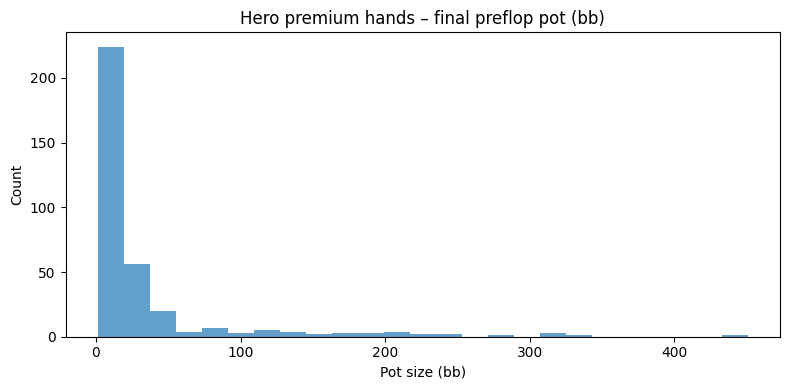

In [12]:
if not hero_events.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    hero_events['final_preflop_pot_bb'].plot(kind='hist', bins=25, alpha=0.7, ax=ax)
    ax.set_title('Hero premium hands – final preflop pot (bb)')
    ax.set_xlabel('Pot size (bb)')
    ax.set_ylabel('Count')
    plt.tight_layout()
else:
    print('Hero pot-size distribution unavailable. No hero events found.')


,hero_to_amount_bucket,hands,call_rate,raise_rate,all_in_rate
0,0-8bb,312,52.564103,0.641026,8.012821
1,12-16bb,5,80.000000,0.000000,20.000000
2,24bb+,2,50.000000,0.000000,50.000000
3,8-12bb,26,53.846154,3.846154,11.538462


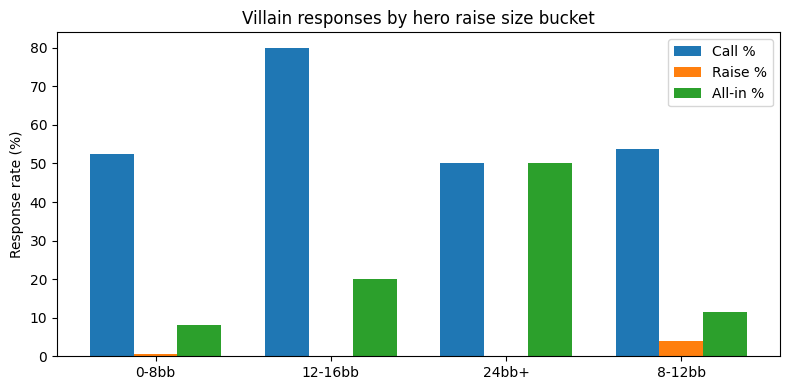

In [13]:
if not hero_events.empty:
    rate_table = (
        hero_events.groupby('hero_to_amount_bucket')
        .agg(
            hands=('hand_id', 'count'),
            call_rate=('responders_call', lambda x: (x > 0).mean() * 100),
            raise_rate=('responders_raise', lambda x: (x > 0).mean() * 100),
            all_in_rate=('responders_all_in', lambda x: (x > 0).mean() * 100),
        )
        .reset_index()
        .sort_values('hero_to_amount_bucket')
    )
    display(rate_table)
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(rate_table))
    width = 0.25
    ax.bar(x - width, rate_table['call_rate'], width, label='Call %')
    ax.bar(x, rate_table['raise_rate'], width, label='Raise %')
    ax.bar(x + width, rate_table['all_in_rate'], width, label='All-in %')
    ax.set_xticks(x)
    ax.set_xticklabels(rate_table['hero_to_amount_bucket'])
    ax.set_ylabel('Response rate (%)')
    ax.set_title('Villain responses by hero raise size bucket')
    ax.legend()
    plt.tight_layout()
else:
    print('Response-rate visualisation unavailable. No hero events found.')


### Notes

- `hero_line` buckets capture opens, iso-raises, 3-bets, and deeper re-raises. Adjust `determine_line_category` if you want alternative labelling.
- Extend `PREMIUM_COMBOS` or tighten stack filters via `MIN_EFFECTIVE_STACK_BB` for targeted heuristics.
- To add more visuals (e.g. opponent-specific breakdowns), build on `response_df` which now records every villain outcome alongside hero context.
